# Mixture Density Network

**Goal:** When I trained flow models, I was able to see $\approx$ 10% error when interpolating into the SR.

<img src='figures/interp2/rnvp_5vars_5layer_H_64_lr_0.001_decay_1e-06/SR_hh_vars_epoch900.pdf'>

However, since the extrapolation performace was $\approx$ the same between the two models, an open question is *Are the flow models more performant than the Gaussian fits because it's taking advantage of the correlations and more of the underlying dynamics, or simply becuase it's using a more expressive distribution?*

To answer this question, I want to train a **mixture density network** [link](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf) on the box w/o the SR and test the extrapolation performance!!

With this problem, there *sholdn't* be that many hyper parameters to vary:
1. Number of hidden layers
2. Number of "modes"
3. Learning rate

I could also add more layers, but I'm *not* convinced that this will be necessary rn.


In [103]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d
from scipy.stats import norm 

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from eventDisplays import rainbow_text

import torch
from torch import nn
from torch.distributions import Normal, Categorical,OneHotCategorical

from mdn import MixtureDensityNetwork
from densityEstimate import *
from densityPlots import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
d = data()

# Add the 2b and deta_hh cuts
mh1_mask = (d.df.m_h1 > 126-45) & (d.df.m_h1 < 126+45)
mh2_mask = (d.df.m_h2 > 116-45) & (d.df.m_h2 < 116+45)
mask = mh1_mask & mh2_mask 

mask = mask & (d.df.abs_deta_hh < 1.5) & (d.df.ntag==2)

d.mlPrepare(mask,['log_m_hh_cor2'])

../data/data_16_PFlow-MAY2019-5jets/df_f_0.22_NNT_HCs.h5


In [11]:
d.df.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_hh', 'pt_hh', 'X_wt', 'm_hh_cor', 'pT_h1',
       'eta_h1', 'phi_h1', 'm_h1', 'dRjj_h1', 'pT_h2', 'eta_h2', 'phi_h2',
       'm_h2', 'dRjj_h2', 'pT_2', 'pT_4', 'eta_i', 'dRjj_1', 'dRjj_2',
       'cosThetaStar', 'cosTheta1', 'cosTheta2', 'Phi', 'Phi1', 'HT', 'MDR',
       'MDpT', 'cut_deta_hh', 'cut_Xwt', 'm_hh_cor2', 'log_m_hh_cor2',
       'abs_deta_hh'],
      dtype='object')

In [9]:
mask

0          False
1          False
2          False
3           True
4          False
           ...  
7496806    False
7496807    False
7496808    False
7496809    False
7496810    False
Length: 7496811, dtype: bool

**Load in the dataset**

In [124]:
nSelectedJets = 5

subDir = 'data_16_PFlow-MAY2019'
if nSelectedJets != 4:
    subDir += f'-{nSelectedJets}jets'
    
trigger ='2016_triggers'

fDir = f"../data/{subDir}/"

tag = '_NNT_HCs'
fout = f"{fDir}df_f_0.22{tag}.h5"

df = pd.read_hdf(fout,key='df')

In [6]:
df.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            7496801, 7496802, 7496803, 7496804, 7496805, 7496806, 7496807,
            7496808, 7496809, 7496810],
           dtype='int64', length=7496811)

In [13]:
for c in df.columns:
    print(c)

run_number
event_number
mc_sf
ntag
njets
kinematic_region
m_hh
pt_hh
X_wt
m_hh_cor
pT_h1
eta_h1
phi_h1
m_h1
dRjj_h1
pT_h2
eta_h2
phi_h2
m_h2
dRjj_h2
pT_2
pT_4
eta_i
dRjj_1
dRjj_2
cosThetaStar
cosTheta1
cosTheta2
Phi
Phi1
HT
MDR
MDpT
cut_deta_hh
cut_Xwt


In [125]:
df['m_hh_cor2'] = df['m_hh'] - df['m_h1'] - df['m_h2'] + 250
df['log_m_hh_cor2'] = np.log(df['m_hh'] - df['m_h1'] - df['m_h2'])

df['abs_deta_hh'] = np.abs(df['eta_h1']-df['eta_h2'])

In [126]:
mh2_edges = np.linspace(116-45,116+45,19)
mh1_edges = np.linspace(126-45,126+45,19) 

Since my other flows notebooks are training w/ the $\Delta \eta_{hh}$ cut, it's reasonable to do that here as well.

In [128]:
mh1_mask = (df.m_h1 > 126-45) & (df.m_h1 < 126+45)
mh2_mask = (df.m_h2 > 116-45) & (df.m_h2 < 116+45)

#df['SR'] = (np.sqrt((10*(df.m_h1-120)/df.m_h1)**2+(10*(df.m_h2-110)/df.m_h2)**2) < 1.6)
zoom_mask = mh1_mask & mh2_mask & (df.ntag==2) & ~(df.kinematic_region==0) &(df.abs_deta_hh < 1.5)

**Preprocess the dataset**

In [129]:
X = df.loc[zoom_mask,['m_h1','m_h2','log_m_hh_cor2']]

scalar = StandardScaler()
X_norm = scalar.fit_transform(X)

In [130]:
N = X_norm.shape[0]
ix = np.arange(N)

np.random.seed(10)
np.random.shuffle(ix)

N_tr = np.floor(.4*N).astype(int)
N_val = np.floor(.5*N).astype(int)

ix_tr = ix[:N_tr]
ix_val = ix[N_tr:N_val]
ix_te = ix[N_val:]

In [131]:
X_tr = torch.from_numpy(X_norm[ix_tr,:2]).float()
Y_tr = torch.from_numpy(X_norm[ix_tr,-1].reshape(-1,1)).float()

X_val = torch.from_numpy(X_norm[ix_val,:2]).float()
Y_val = torch.from_numpy(X_norm[ix_val,-1].reshape(-1,1)).float()

X_te = torch.from_numpy(X_norm[ix_te,:2]).float()
Y_te = torch.from_numpy(X_norm[ix_te,-1].reshape(-1,1)).float()

**Goal:** Make an MDN class!!

Play around with the options I have for defining the $\alpha$s.

In [18]:
logits = torch.tensor([1,5,3,.1,2])

In [19]:
alphas1 = nn.Softmax(dim=0)(logits)
alphas1

tensor([0.0151, 0.8258, 0.1118, 0.0061, 0.0411])

In [20]:
s = Categorical(logits=logits)
x = s.sample(sample_shape=torch.Size([100000]))

In [21]:
n,e,_ = plt.hist(x, 5,(-0.5,4.5),histtype='step',density=True,color='C4',linewidth=1.5,
                 label='Categorial samples')
plt.plot(.5*(e[1:]+e[:-1]), alphas1, 'k.',label='Softmax probs')
plt.xlabel('Classes',fontsize=15)
plt.ylabel('Probability',fontsize=15)
plt.xticks(range(5))
plt.legend(fontsize=12.5)
plt.show()

Ok - so I understand how these modules *work*, and they're giving the same answer.

**Options:**
1. I could either use the softmax to predict *weights* for each of the kernels
2. I could use a Categorical distribution to decide *which* of the modes to sample from


The classes below have been taken from [this repo](https://github.com/tonyduan/mdn/blob/master/mdn/models.py).

In [24]:
MixtureDensityNetwork(2,1,1,100)

MixtureDensityNetwork(
  (pi_network): CategoricalNetwork(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (normal_network): MixtureDiagNormalNetwork(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [34]:
mdn(X_tr)

(OneHotCategorical(),
 Normal(loc: torch.Size([69889, 1, 1]), scale: torch.Size([69889, 1, 1])))

Fortunately, training for this problem will be very similar to the training for the Gaussian-density network, so I can just *copy over that code*!

In [60]:
learning_rate=1e-2

In [67]:
s.shape

torch.Size([69889, 1])

In [71]:
pis.shape

torch.Size([69889, 5, 1])

In [74]:
counts = pis.argmax(axis=1).squeeze()

In [101]:
n, e,_ = plt.hist(counts,k,(-0.5,k-.5),histtype='step',density=True)
plt.show()

In [173]:
s, pis = model.sample(Xi)

In [177]:
pis.shape[1]

5

In [178]:
def test_mdn_prediction(mdn,Xi,Yi,k,rlim=(.5,2),title=''):
    '''
    For a pair of predicted and true outputs, (Xi, Yi), compared the MDN pred
    with the truth, and visualize the modes that got fit.
    '''

    # Generate samples from the MDN
    s, pis = mdn.sample(Xi)
    k = pis.shape[1]
    
    # Retrieve the *counts* that each of the modes got sampled from
    counts = pis.argmax(axis=1).squeeze()
    n, _ = np.histogram(counts,k,(-0.5,k-.5),density=True)
    
    fig = plt.figure(figsize=(6.4, 7))
    gs = gridspec.GridSpec(3,1)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

    n_pred,e,_ = ax1.hist(s.squeeze(),100,(-5,5),color='paleturquoise',label='MDN pred')

    ls, lc = [], []

    for ki,ni in enumerate(n):
        c = f'C{ki}'
        ax1.hist(s[counts==ki].squeeze(),100,(-5,5),histtype='step',linewidth=1.5,color=c)
        ls.append(r'$\alpha$'+f'$_{ki}$ = {ni:.2f}')
        lc.append(c)

    n_2b,_,_ = ax1.hist(Yi.squeeze(),100,(-5,5),histtype='step',linewidth=1.5,color='k',label='2b')

    ax1.set_ylabel('Entries',fontsize=15)
    ax1.legend(fontsize=15)
    rainbow_text(-5,np.max(n_2b),ls,lc,ax=ax1,ha='left',va='top',yoffset=1,fontsize=12)
    ax1.set_title(title,fontsize=15,loc='left')
    
    
    xx = 0.5*(e[1:]+e[:-1])
    ax2.plot(xx, n_pred / n_2b, 'o', color='paleturquoise')
    ax2.plot(xx,np.ones_like(xx),'k--')
    ax2.set_xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
    ax2.set_ylabel('pred / 2b',fontsize=15)
    ax2.set_ylim(rlim)

    plt.show()

I think it would be nice to also print an estimate of the modes with like `rainbow_text` on the LHS, and make this a ratio plot so we can test the convergence.

In [163]:
# H = 100

# nModes = [4]

# train_loss = { k: [] for k in nModes }
# val_loss   = { k: [] for k in nModes }

# for k in nModes:
    
#     # Define a model
#     mdn = MixtureDensityNetwork(2,1,k,100)
    
#     # Define an optimizer
#     opt = torch.optim.Adam(mdn.parameters(),lr=learning_rate)
    
# #     subDir = f'mdn_{}modes_{H}_lr_{learning_rate}'
# #     figDir = f'figures/interp2/{subDir}'
# #     if not os.path.exists(figDir): 
# #         os.mkdir(figDir)
    
#     for t in range(101):

#         # Zero out the gradients
#         opt.zero_grad()
#         mdn.train()

#         loss = torch.mean(mdn.loss(X_tr,Y_tr))
        
#         loss.backward()
#         opt.step()

#         train_loss[k].append(loss.item())
        
# #         if t%100 == 0:
# #             evalErrorsOneMode(df,zoom_mask,ix_tr,i0_toy,i1_toy,mus,sigmas,s,figDir=figDir)
            
#         # Compute the validation loss
#         mdn.eval()
        
#         loss = torch.mean(mdn.loss(X_val,Y_val))
#         val_loss[k].append(loss.item())


#     # Save the weights
        

**Plot the evolution of the loss function as you vary across epochs.**

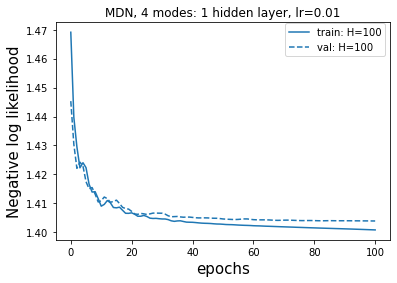

In [204]:
for i, k in enumerate(nModes):
    plt.plot(train_loss[k],color=f'C{i}',label=f'train: H={H}')
    plt.plot(val_loss[k],color=f'C{i}',linestyle='--',label=f'val: H={H}')
plt.xlabel('epochs',fontsize=15)
plt.ylabel('Negative log likelihood',fontsize=15)
plt.legend(bbox_to_anchor=(1,1.02))
plt.title(f'MDN, {k} modes: 1 hidden layer, lr={learning_rate}')
#plt.savefig('figures/interp2/nll_vary_nHidden.pdf',bbox_inches='tight')
plt.show()

Ok, so there's a *bit* of overfitting going on - but this is ok (i.e, not the end of the world)

In [46]:
modelDict = {}

In [50]:
for i in range(5):

    subDir = f'{(d.subDir)}_2b_detaCut/'
    mdn = MDN(subDir,5e-3,['log_mhh_cor_2'],i,4,100,load_model=True)
    model = mdn.model
    
    key = f'4modes_H_100_lr_5e-3_iter{i}'
    modelDict[key] = model
    
#     mpi = MDN_Plots(mdn)
#     mpi.plotAll(d)
    

I'm going to *start off* demonstrating what the variations from random initializations look like, and then compare with using the median predictions.

In [53]:
X_SR,Y_SR = d.X_SR, d.Y_SR

In [122]:
title = '2b pairAGraph SR, $|\Delta \eta_{hh}| < 1.5$'
title += '\nMDN 4 modes, 100 hidden units'

In [124]:
figDir = 'figures/data_16_PFlow-MAY2019-5jets_2b_detaCut/mdn_4_H_100_lr_0.005'

In [126]:
fig = plt.figure(figsize=(6.4, 7))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

e = np.linspace(-5,5,101)
xx = 0.5*(e[:-1]+e[1:])
n_2b, _ = np.histogram(Y_SR.squeeze(),100,(-5,5))

k4_1sample = np.zeros((5,100))

for i,color in enumerate(['pink','lightpink','hotpink','deeppink','mediumvioletred']):
    
    key = f'4modes_H_100_lr_5e-3_iter{i}'
    
    # Sample 
    si, _ = modelDict[key].sample(X_SR)
    
    # Plot
    n_pi, _, _ = ax1.hist(si.squeeze(), 100, (-5,5),color=color,label=f'iter {i}',histtype='step',linewidth=1.5)
    ax2.plot(xx,n_pi/n_2b,'.',color=color)
    
    k4_1sample[i] = n_pi
    
    
# Plot 2b
ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',label='2b')

# Make the plot pretty!
ax1.set_ylabel('Entries',fontsize=15)
ax1.legend(fontsize=15)
ax1.set_title(title,fontsize=12,loc='left')
ax1.text(.025,.96,f'1 sample / training',ha='left',va='top',fontsize=15,transform=ax1.transAxes)

ax2.plot(xx,np.ones_like(xx),'k--')
ax2.set_xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
ax2.set_ylabel('pred / 2b',fontsize=15)
ax2.set_ylim(.8,1.2)

plt.savefig(f'{figDir}/log_m_hh_cor2_5iter_1sample_SR.pdf',bbox_inches='tight')


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21

I really like the way this looks! 

How does the spread of the predictions compare with the Poissonian errors?

In [127]:
plt.plot(xx,k4_1sample.std(axis=0),'hotpink',marker='o',linewidth=0,label='training iters')
plt.plot(xx,np.sqrt(n_2b),'k',label='2b Poisson')

plt.xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
plt.ylabel('Error',fontsize=15)
plt.title(title,loc='left',fontsize=12)
plt.legend(fontsize=12)

ax = plt.gca()
ax.text(.025,.96,f'1 sample / training',ha='left',va='top',fontsize=15,transform=ax.transAxes)

plt.savefig(f'{figDir}/err_5iter_1sample_SR.pdf',bbox_inches='tight')
plt.show()

Interesting - the model variations seems to be probing the model errors as well.

**Now look at a smoothed prediction instead of ...**

In [95]:
X_SR, Y_SR = d.X_SR, d.Y_SR

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


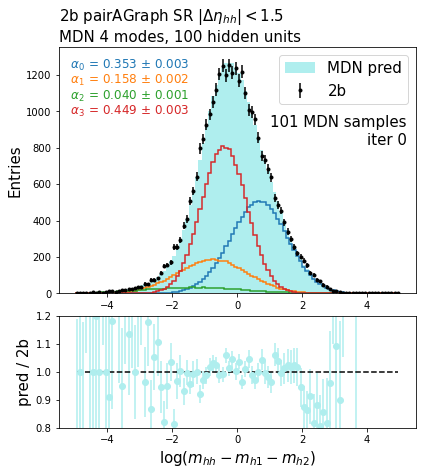

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


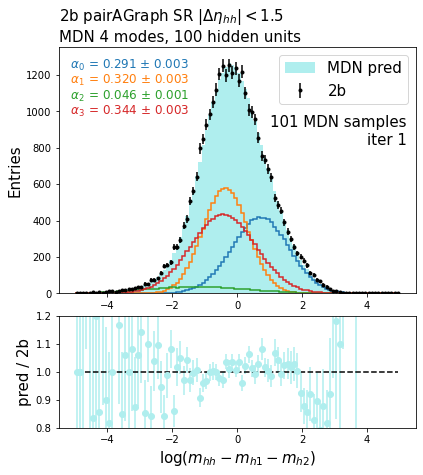

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


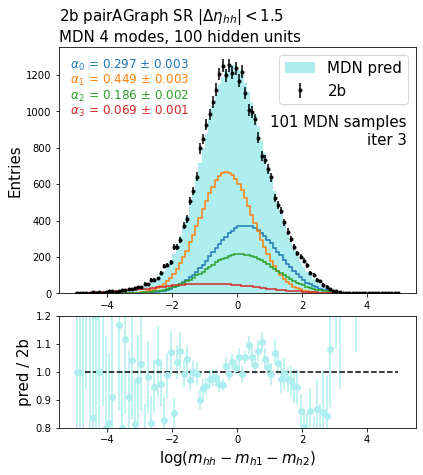

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:151: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


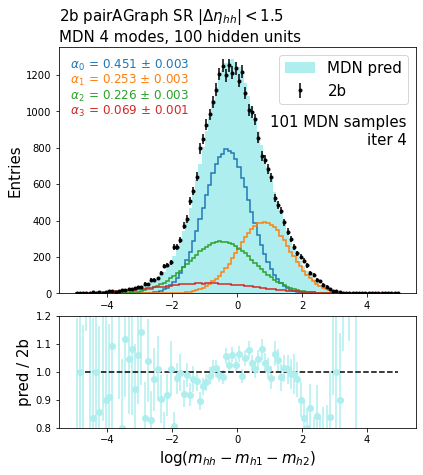

In [107]:
mpDict = {}

for i in range(5):

    subDir = f'{(d.subDir)}_2b_detaCut/'
    mdn = MDN(subDir,5e-3,['log_mhh_cor_2'],i,4,100,load_model=True)
    mp = MDN_Plots(mdn,save=False)        
    mp.samplePrediction(X_SR,Y_SR,title=title)#,tag=f'_{set}')

    #print(mp.n_pred)
    
    key = f'4modes_H_100_lr_5e-3_iter{i}'
    mpDict[key] = mp
    

In [101]:
mpDict[key].nPreds

101

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22

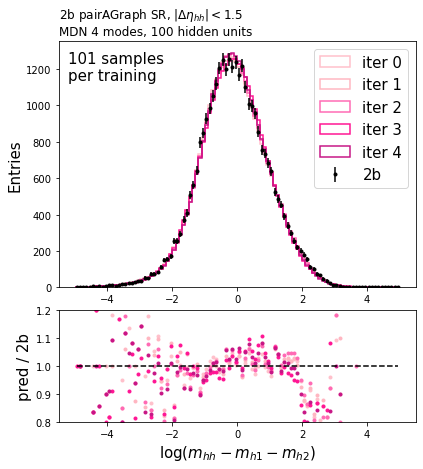

In [131]:
fig = plt.figure(figsize=(6.4, 7))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

e = np.linspace(-5,5,101)
xx = 0.5*(e[:-1]+e[1:])
n_2b, _ = np.histogram(Y_SR.squeeze(),100,(-5,5))

k4_1sample = np.zeros((5,100))

for i,color in enumerate(['pink','lightpink','hotpink','deeppink','mediumvioletred']):
    
    key = f'4modes_H_100_lr_5e-3_iter{i}'
    
    # Sample 
    wi = mpDict[key].n_pred
    
    # Plot
    n_pi, _, _ = ax1.hist(xx, 100, (-5,5),color=color,label=f'iter {i}',histtype='step',linewidth=1.5,
                          weights=wi)
    ax2.plot(xx,n_pi/n_2b,'.',color=color)
    
    k4_1sample[i] = n_pi
    
    
# Plot 2b
ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',label='2b')

# Make the plot pretty!
ax1.set_ylabel('Entries',fontsize=15)
ax1.legend(fontsize=15)
ax1.set_title(title,fontsize=12,loc='left')
ax1.text(.025,.96,f'{mp.nPreds} samples\nper training',ha='left',va='top',fontsize=15,transform=ax1.transAxes)

ax2.plot(xx,np.ones_like(xx),'k--')
ax2.set_xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
ax2.set_ylabel('pred / 2b',fontsize=15)
ax2.set_ylim(.8,1.2)

plt.savefig(f'{figDir}/log_m_hh_cor2_5iter_101samples_med_SR.pdf',bbox_inches='tight')
plt.show()

Ok - by this point I'm pretty convinced that the interpolation is *failing* now. The trainings with different random initializations are *off* in a consistent way.

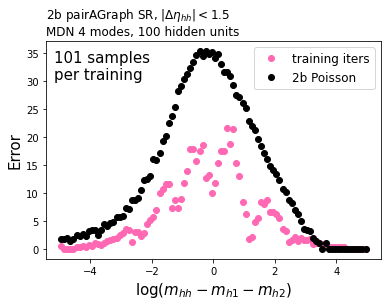

In [130]:
plt.plot(xx,k4_1sample.std(axis=0),'hotpink',marker='o',linewidth=0,label='training iters')
plt.plot(xx,np.sqrt(n_2b),'k',marker='o',linewidth=0,label='2b Poisson')

plt.xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
plt.ylabel('Error',fontsize=15)
plt.title(title,loc='left',fontsize=12)
plt.legend(fontsize=12)

ax = plt.gca()
ax.text(.025,.96,f'{mp.nPreds} samples\nper training',ha='left',va='top',fontsize=15,transform=ax.transAxes)

plt.savefig(f'{figDir}/err_5iter_101samples_med_SR.pdf',bbox_inches='tight')
plt.show()

**Message:** Taking the standard deviation betweewn bootstraps is *smaller* than the Poissonian error... interesting!

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


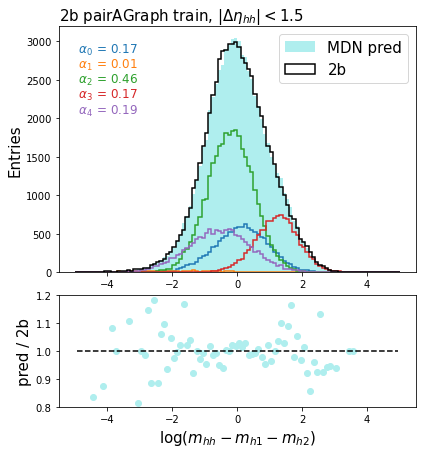

In [213]:
test_mdn_prediction(model,X_tr,Y_tr,k, rlim=(.8,1.2),title='2b pairAGraph train, $|\Delta \eta_{hh}| < 1.5$')

Ok - *aweseome*, this distribution looks sufficiently flexible to model the training dataset.

(I might need to tune the hyperparameters a bit more though, but this is promising.)

In [144]:
SR_mask = (df.ntag==2) & (df.abs_deta_hh < 1.5) & (df.kinematic_region==0)

cols = ['m_h1','m_h2','log_m_hh_cor2']
SR_norm  = scalar.transform(df.loc[SR_mask,cols])

X_SR = torch.from_numpy(SR_norm[:,:2]).float()
Y_SR = torch.from_numpy(SR_norm[:,2:].reshape(-1,1)).float()

In [72]:
model

MixtureDensityNetwork(
  (pi_network): CategoricalNetwork(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=3, bias=True)
    )
  )
  (normal_network): MixtureDiagNormalNetwork(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=6, bias=True)
    )
  )
)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


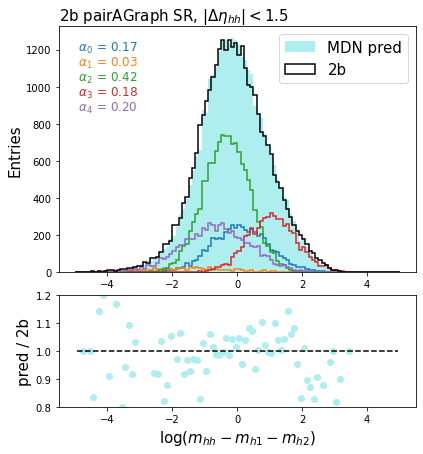

In [208]:
test_mdn_prediction(model,X_SR,Y_SR,3, rlim=(.8,1.2),title='2b pairAGraph SR, $|\Delta \eta_{hh}| < 1.5$')

It would be really interesting to see the *spread* in this distribution from the prediction error!

I'm going to *prototype* it below - and then I'll see how to functionify it!

**Question:** How does the error from random initializations compare to the error from taking more samples from the prediction?

In [201]:
#Xi,Yi = X_tr, Y_tr
Xi,Yi = X_SR, Y_SR

In [218]:
nPreds = 101
rlim=(.8,1.2)

hists = np.zeros((100,nPreds))
alphas = np.zeros((k,nPreds))
modes = np.zeros((100,k,nPreds))

for i in range(nPreds):

    # Generate samples from the MDN
    s, pis = model.sample(Xi)
    
    k = pis.shape[1]
    
    # Retrieve the *counts* that each of the modes got sampled from
    counts = pis.argmax(axis=1).squeeze()
    n, _ = np.histogram(counts,k,(-0.5,k-.5),density=True)
    alphas[:,i] = n
    
    n_pi,e = np.histogram(s.squeeze(),100,(-5,5))
    hists[:,i] = n_pi

    for ki,ni in enumerate(n):
        
        m, _ = np.histogram(s[counts==ki].squeeze(),100,(-5,5)) 
        
        modes[:,ki,i] = m
        

In [297]:
f'figures/{mdn_test.modelDir[7:]}'

'figures/data_16_PFlow-MAY2019-5jets_2b_detaCut///mdn_5_H_100_lr_0.005_iter0/'

In [ ]:
mps = {'md'}

In [ ]:
for k i

In [41]:
mdn_test.iter

0

In [38]:
mp = MDN_Plots(mdn_test)

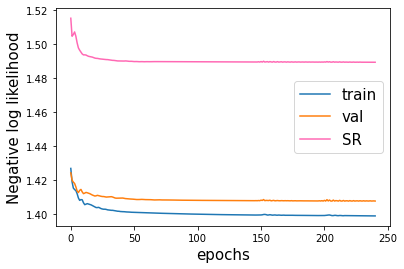

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:150: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:150: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


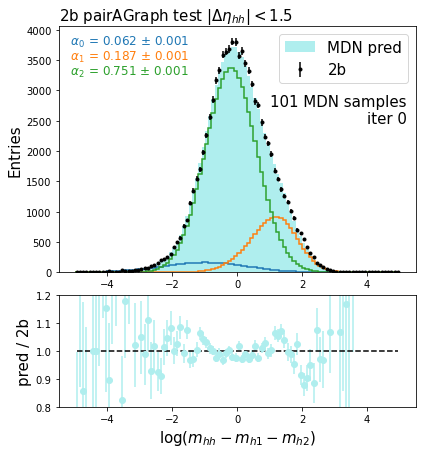

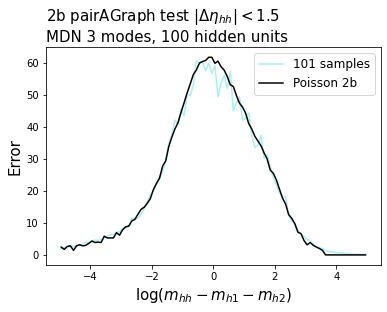

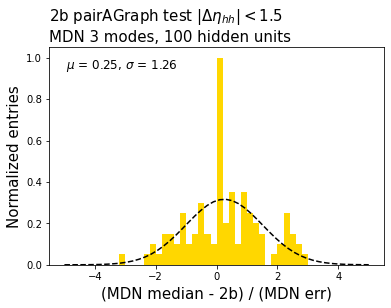

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:150: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:150: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(self.xx, n_pred / n_2b, err/n_2b, fmt='o', color='paleturquoise',label='sampling variation')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


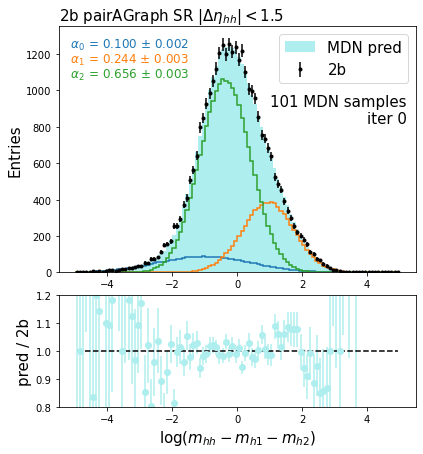

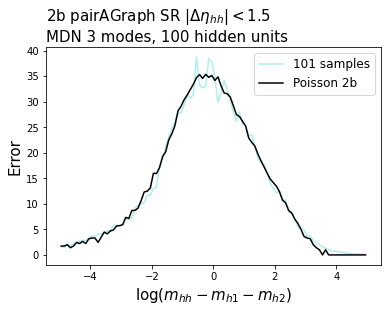

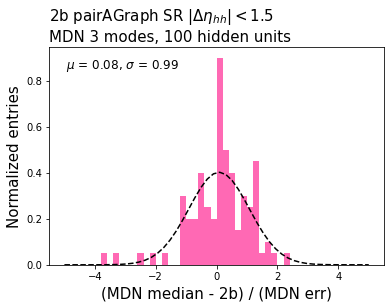

In [36]:
mp.plotAll(d)

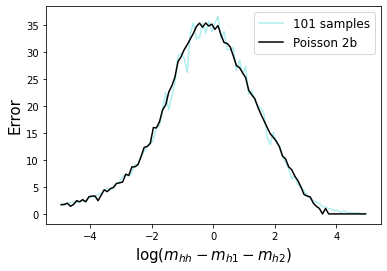

In [206]:
plt.plot(xx,err,color='paleturquoise',label='101 samples')
plt.plot(xx,np.sqrt(n_2b),color='k',  label='Poisson 2b')

plt.xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$',fontsize=15)
plt.ylabel('Error',fontsize=15)

plt.xlabel('$\log (m_{hh} - m_{h1} - m_{h2})$')
plt.legend(fontsize=12,loc='upper right')

Wow!! Was this expected?

I think so - or at least, Sean definitely thought yes, that if I had a density estimate, I don't gain anything other than just Poissonian errors from sampling from this density.


**While my models are training, I want to understand a little more what this plotting framework looks like**

To do this - I'll need to implement the loadModel functionality!

In [59]:
d.subDir

'data_16_PFlow-MAY2019-5jets'

Ok - so these studies are still very much *works in progress* but I'd sort of like to start understanding what the *impact* is of these density, and then I can *finalize* my experiment code.

In [4]:
d.subDir

'data_16_PFlow-MAY2019-5jets'

**Load in the loss and accuracy curves**

In [153]:
mDict = {}

i = 0
nModes = [1,2,3,4,5,6,7,8]
for lr in [1e-2,1e-3]:
    for K in nModes:
        for H in [100,200]:
        
            filename = f'models/{d.subDir}_2b_detaCut/mdn_{K}_H_{H}_lr_{lr}_iter{i}/loss_acc.json'
            if os.path.exists(filename):
                
                with open(filename, 'r') as varfile:
                    metrics = json.load(varfile)

                mDict[f'{K}_{H}_{lr}'] = {k: np.array(v) for k,v in metrics.items()}
                

In [288]:
trainingMetric(metrics,title=f'mdn_{K}_H_{H}_lr_{lr}_iter{i}')

In [154]:
best_hps, best_epoch, minValLoss = [],[],[]

for K in nModes:
    
    # Return the relevant keys from this hp scan
    myKeys = [key for key in mDict.keys() if int(key[0]) == K]
    
    #print(K, myKeys)
    
    vls = [np.min(mDict[k]['val_loss']) for k in myKeys]
    bes = [np.argmin(mDict[k]['val_loss']) for k in myKeys]
    
    vl, e, key = min([(vl, e, key) for vl, e, key in zip(vls,bes,myKeys)])
    print(vl, e, key)
    
    best_hps.append(key)
    best_epoch.append(e)
    minValLoss.append(vl)

1.4146690368652344 74 1_200_0.01
1.4113819599151611 83 2_200_0.01
1.4092116355895996 100 3_200_0.001
1.4085336923599243 97 4_200_0.01
1.408258318901062 100 5_100_0.001
1.4079993963241577 100 6_100_0.01
1.4072811603546143 100 7_200_0.001
1.4073703289031982 83 8_100_0.01


- These models are just training until the end, they're simple enough that they don't seem to be overfitting.
- So, I don't really need to go through the exercise of finding the epoch with the smallest validation loss.

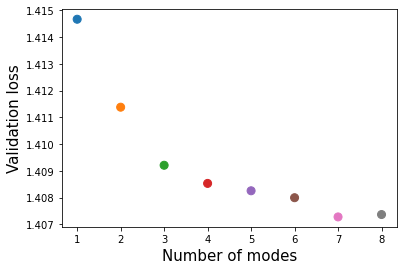

In [162]:
colors = [f'C{i}' for i in range(len(nModes))]

plt.scatter(nModes,minValLoss, 64,color=colors)#,label=best_hps)
plt.xlabel('Number of modes',fontsize=15)
plt.ylabel('Validation loss',fontsize=15)
# I'll need to make a custom legend for this!
#plt.legend()
plt.show()

Ok-  I really like this plot!! I'll probably want to include 5 modes as well though. 

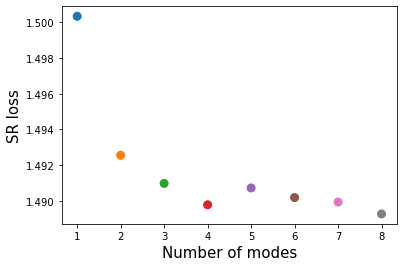

In [156]:
SRloss = [mDict[hpi]['SR_loss'][-1] for hpi in best_hps]

plt.scatter(nModes,SRloss, 64,color=colors)#,label=best_hps)
plt.xlabel('Number of modes',fontsize=15)
plt.ylabel('SR loss',fontsize=15)
# I'll need to make a custom legend for this!
#plt.legend()
plt.show()

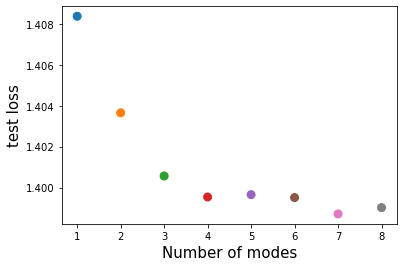

In [157]:
testLoss = [mDict[hpi]['test_loss'][-1] for hpi in best_hps]

plt.scatter(nModes,testLoss, 64,color=colors)#,label=best_hps)
plt.xlabel('Number of modes',fontsize=15)
plt.ylabel('test loss',fontsize=15)
# I'll need to make a custom legend for this!
#plt.legend()
plt.show()

In [158]:
trainLoss = [mDict[hpi]['train_loss'][-1] for hpi in best_hps]

plt.scatter(nModes,testLoss, 64,color=colors)#,label=best_hps)
plt.xlabel('Number of modes',fontsize=15)
plt.ylabel('Training loss',fontsize=15)
# I'll need to make a custom legend for this!
#plt.legend()
plt.show()

In [159]:
minValLoss

[1.4146690368652344,
 1.4113819599151611,
 1.4092116355895996,
 1.4085336923599243,
 1.408258318901062,
 1.4079993963241577,
 1.4072811603546143,
 1.4073703289031982]

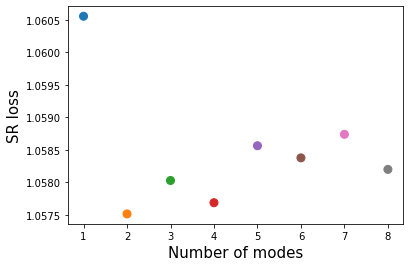

In [160]:
plt.scatter(nModes, np.array(SRloss) / np.array(minValLoss), 64,color=colors)#,label=best_hps)
plt.xlabel('Number of modes',fontsize=15)
plt.ylabel('SR loss',fontsize=15)
# I'll need to make a custom legend for this!
#plt.legend()
plt.show()

Ok, this is *interesting*.

**Lessons:**
1. A MDN with **3 modes** has enough flexbility to model the training data, and it looks like we're great in terms of training stats because the training, validation and test losses all look the *same*.
2. The SR loss looks follows the same basic trend as the training and validation regions, except that the losses are *consistently 5% higher*

Something else that will be interesting is to see how both of these models do in terms of prediction when we give them *less* training data.




Ok - I want to get some *prediction code* up and running!!


Let's figure out how to *sample* so that I can *evaluate* some distributions.


**Study:** What's the *variation* I get changing the number of random initializations?

**Issue:** I didn't like it how the plot below made it hard to see the variation between trainings.

**Plan:** Let's try to check the average loss between training iterations using an error bar on the validation / test loss.

In [164]:
H = 100
lr = 5e-3

iterAvgs = {}
Ks = [3,4,5]

for K in Ks:
    iterAvgs[K] = {f'{s}_loss': [] for s in ['train','val','test','SR']}
    
    for i in range(5):
    
        # Load in the metrics
        filename = f'models/{d.subDir}_2b_detaCut/mdn_{K}_H_{H}_lr_{lr}_iter{i}/loss_acc.json'
        if os.path.exists(filename):

            with open(filename, 'r') as varfile:
                metrics = json.load(varfile)

            be = np.argmin(metrics['val_loss'])    
            #print(be)
             
            iterAvgs[K]['train_loss'].append(metrics['train_loss'][be])
            iterAvgs[K]['val_loss'].append(metrics['val_loss'][be])
            iterAvgs[K]['test_loss'].append(metrics['test_loss'][be])
            iterAvgs[K]['SR_loss'].append(metrics['SR_loss'][be])
                
            #mDict[f'{K}_{H}_{lr}'] = {k: np.array(v) for k,v in metrics.items()}
        else:
            print(f'Error: {filename} does not exist')

In [166]:
np.vstack([np.array(iterAvgs[K]['train_loss']) for K in Ks])

array([[1.39908922, 1.39888108, 1.39993489, 1.39997065, 1.40340436],
       [1.39882362, 1.39888334, 1.39898264, 1.40058315, 1.39893591],
       [1.3986814 , 1.39883435, 1.39863288, 1.39863586, 1.39878273]])

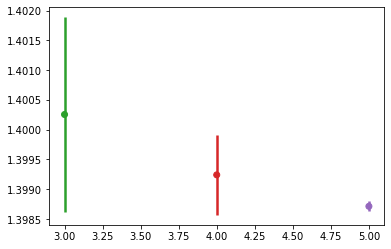

In [167]:
tr_loss = [np.mean(np.array(iterAvgs[K]['train_loss'])) for K in Ks ]
tr_err = [np.std(np.array(iterAvgs[K]['train_loss'])) for K in Ks ]

plt.errorbar(Ks,tr_loss,tr_err,ecolor=['C2','C3','C4'],linewidth=0,elinewidth=2.5)
plt.scatter(Ks,tr_loss,color=['C2','C3','C4'],marker='o')

plt.show()

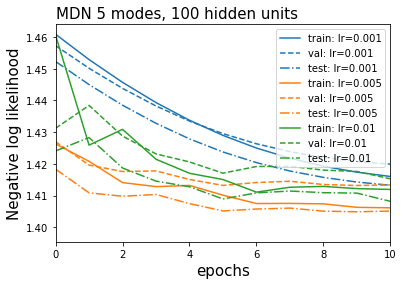

In [306]:
K = 5
H=100
for i, lr in enumerate([1e-3,5e-3, 1e-2]):
    
    filename = f'models/{d.subDir}_2b_detaCut/mdn_{K}_H_{H}_lr_{lr}_iter0/loss_acc.json'
    if os.path.exists(filename):

        with open(filename, 'r') as varfile:
            metrics = json.load(varfile)
        
        plt.plot(metrics['train_loss'], color=f'C{i}', label=f'train: lr={lr}')
        plt.plot(metrics['val_loss'], color=f'C{i}', label=f'val: lr={lr}',linestyle='--')
        plt.plot(metrics['test_loss'], color=f'C{i}', label=f'test: lr={lr}',linestyle='-.')
        
plt.xlabel('epochs',fontsize=15)
plt.ylabel('Negative log likelihood',fontsize=15)
plt.title(f'MDN {K} modes, {H} hidden units',fontsize=15,loc='left')
plt.legend()
plt.savefig(f'figures/data_16_PFlow-MAY2019-5jets_2b_detaCut/mdn_hp_scans/mdn_{K}modes_H_{H}_vary_lr.pdf',
            bbox_inches='tight')
plt.xlim(0,10)
plt.show()

In [300]:
ix= np.arange(100)
ix

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [301]:
np.random.shuffle(ix)

In [302]:
ix

array([98, 13, 82, 20, 94, 17, 19, 63, 99, 70, 39,  3, 38, 45, 32, 87, 72,
       42, 89, 12, 51, 37, 93, 59, 16, 40, 74, 53, 58, 33, 55, 73, 36, 88,
       44, 62, 54, 68, 22,  1,  2, 27, 71, 47, 50, 41, 29, 85, 84, 61, 78,
       57, 31, 28, 96, 15,  0,  8, 67, 64, 65,  6,  4, 83, 24, 79, 49, 21,
       26, 75, 95, 46,  9, 81, 52, 25, 92, 80, 30, 91, 11, 34, 97, 10, 90,
       86, 77, 14,  5, 35, 23, 66, 43, 48, 56, 76, 69,  7, 60, 18])

In [303]:
np.unique(ix)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

I'm *so confused*, I have *no idea* what could be going on...

**Summarizing**

I eneded up doing a *semi-thorough* hyperparameter scan with
- $K \in \{1, \ldots , 9\}$
- $H \in \{ 50, 100, 200, 400 \}$

with **5** random initializations for each of the configurations and keeping the lr *set* at 5e-3 for all experiments.

In [235]:
sets = ['train','val','test','SR']

Hs = [50, 100, 200, 400]
ls = {s:np.zeros((9,len(Hs),5)) for s in sets}

lr = 5e-3

for ki,K in enumerate(range(1,10)):
    for hi,H in enumerate(Hs):
        for i in range(5):
            
            # Load in metrics            
            filename = f'models/{d.subDir}_2b_detaCut/mdn_{K}_H_{H}_lr_{lr}_iter{i}/loss_acc.json'
            if os.path.exists(filename):

                with open(filename, 'r') as varfile:
                    metrics = json.load(varfile)

                be = np.argmin(metrics['val_loss'])    
                print(f'{K}_H_{H}_iter{i}',be)

                ls['train'][ki,hi,i] = metrics['train_loss'][be]
                ls['val'][ki,hi,i] = metrics['val_loss'][be]
                ls['test'][ki,hi,i] = metrics['test_loss'][be]
                ls['SR'][ki,hi,i] = metrics['SR_loss'][be]


1_H_50_iter0 78
1_H_50_iter1 115
1_H_50_iter2 407
1_H_50_iter3 148
1_H_50_iter4 175
1_H_100_iter0 67
1_H_100_iter1 61
1_H_100_iter2 162
1_H_100_iter3 232
1_H_100_iter4 86
1_H_200_iter0 91
1_H_200_iter1 47
1_H_200_iter2 78
1_H_200_iter3 61
1_H_200_iter4 67
1_H_400_iter0 77
1_H_400_iter1 46
1_H_400_iter2 86
1_H_400_iter3 87
1_H_400_iter4 90
2_H_50_iter0 373
2_H_50_iter1 223
2_H_50_iter2 178
2_H_50_iter3 116
2_H_50_iter4 140
2_H_100_iter0 226
2_H_100_iter1 318
2_H_100_iter2 175
2_H_100_iter3 254
2_H_100_iter4 101
2_H_200_iter0 179
2_H_200_iter1 367
2_H_200_iter2 77
2_H_200_iter3 60
2_H_200_iter4 68
2_H_400_iter0 99
2_H_400_iter1 298
2_H_400_iter2 81
2_H_400_iter3 140
2_H_400_iter4 65
3_H_50_iter0 586
3_H_50_iter1 499
3_H_50_iter2 182
3_H_50_iter3 232
3_H_50_iter4 562
3_H_100_iter0 219
3_H_100_iter1 367
3_H_100_iter2 274
3_H_100_iter3 312
3_H_100_iter4 77
3_H_200_iter0 281
3_H_200_iter1 289
3_H_200_iter2 71
3_H_200_iter3 47
3_H_200_iter4 235
3_H_400_iter0 327
3_H_400_iter1 109
3_H_400_iter

**Let's visualize *all* of them!!**

I.e, for *each* of the metrics, let's show the hidden states.

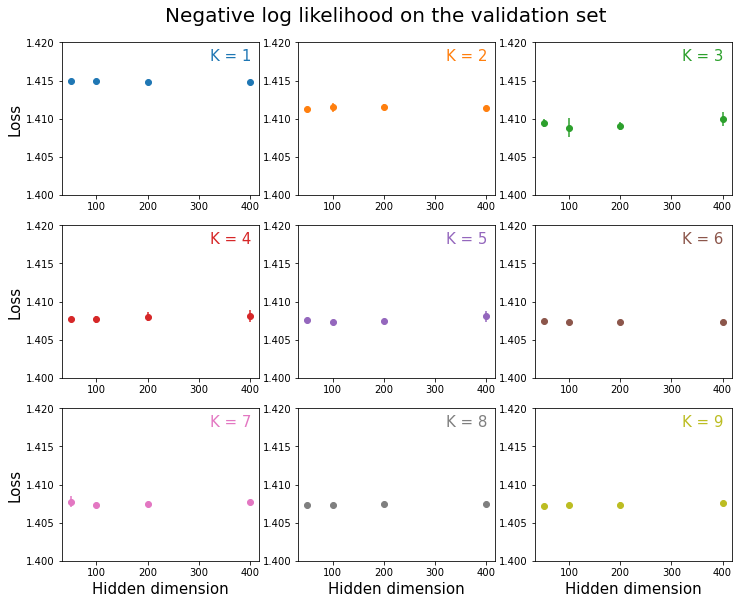

In [287]:
fig, axes = plt.subplots(3,3,figsize=(12,9))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        
        ki = i*3 + j
        ax.errorbar(Hs,np.mean(ls['val'][ki],axis=-1), np.std(ls['val'][ki],axis=-1),
                    fmt='o',color=f'C{ki}')
        
        ax.set_ylim(1.4,1.42)
        ax.text(.96,.96,f'K = {ki+1}',color=f'C{ki}',fontsize=15,ha='right',va='top',transform=ax.transAxes)
        
        if j == 0:
            ax.set_ylabel('Loss',fontsize=15)
        
        if i == 2:
            ax.set_xlabel('Hidden dimension',fontsize=15)
        
# Add a title
fig.suptitle('Negative log likelihood on the validation set',fontsize=20)
fig.subplots_adjust(top=.925)
_
plt.savefig('figures/data_16_PFlow-MAY2019-5jets_2b_detaCut/mdn_hp_scans/val_loss_allK_showH.pdf')

Well - this is *interesting* - I can zoom in to see variations, but if I zoom *out* it's clear that H is *not* a relevant dimension.

In [288]:
fig, axes = plt.subplots(3,3,figsize=(12,9))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        
        ki = i*3 + j
        #ax.text(.5,.5,f'K = {ki+1}',color=f'C{ki}')
        ax.errorbar(Hs,np.mean(ls['SR'][ki],axis=-1), np.std(ls['SR'][ki],axis=-1),
                    fmt='s',color=f'C{ki}')
        
        ax.set_ylim(1.485,1.505)
        ax.text(.96,.96,f'K = {ki+1}',color=f'C{ki}',fontsize=15,ha='right',va='top',transform=ax.transAxes)
        
        if j == 0:
            ax.set_ylabel('Loss',fontsize=15)
        
        if i == 2:
            ax.set_xlabel('Hidden dimension',fontsize=15)
        
# Add a title
fig.suptitle('Negative log likelihood in the SR',fontsize=20)
fig.subplots_adjust(top=.925)
plt.savefig('figures/data_16_PFlow-MAY2019-5jets_2b_detaCut/mdn_hp_scans/SR_loss_allK_showH.pdf')

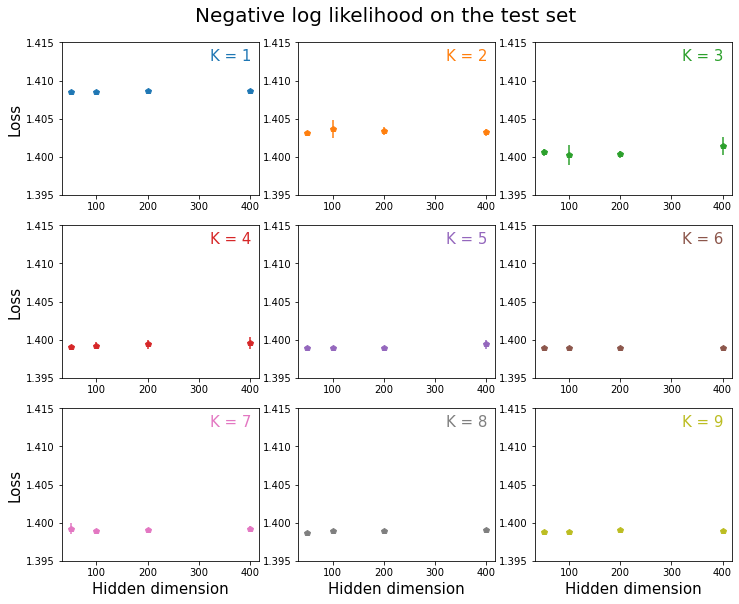

In [293]:
fig, axes = plt.subplots(3,3,figsize=(12,9))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        
        ki = i*3 + j
        #ax.text(.5,.5,f'K = {ki+1}',color=f'C{ki}')
        ax.errorbar(Hs,np.mean(ls['test'][ki],axis=-1), np.std(ls['test'][ki],axis=-1),
                    fmt='p',color=f'C{ki}')
        
        ax.set_ylim(1.395,1.415)
        ax.text(.96,.96,f'K = {ki+1}',color=f'C{ki}',fontsize=15,ha='right',va='top',transform=ax.transAxes)
        
        if j == 0:
            ax.set_ylabel('Loss',fontsize=15)
        
        if i == 2:
            ax.set_xlabel('Hidden dimension',fontsize=15)
        
# Add a title
fig.suptitle('Negative log likelihood on the test set',fontsize=20)
fig.subplots_adjust(top=.925)
#plt.savefig('figures/data_16_PFlow-MAY2019-5jets_2b_detaCut/mdn_hp_scans/SR_loss_allK_showH.pdf')

**Study:** How many modes do I need? It looks like 5 is too many lol

In [253]:
np.std(ls['val'],axis=-1).shape

(9, 4)

In [254]:
his

array([2, 0, 1, 1, 1, 3, 1, 1, 0])

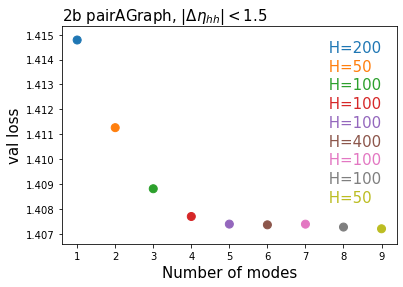

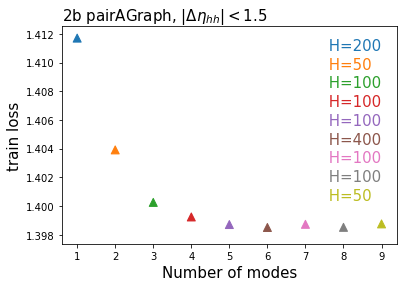

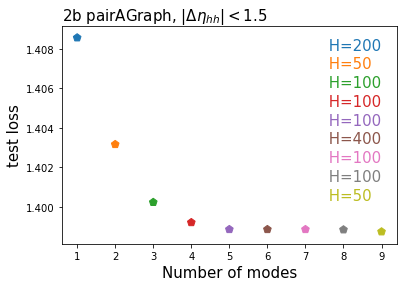

In [308]:
colors = [f'C{i}' for i in range(9)]

his = np.argmin(np.mean(ls['val'],axis=-1),axis=-1)

for s,m in zip(['val','SR','train','test'],['o','s','^','p']):
    
    #mid = np.min(np.mean(ls[s],axis=-1),axis=-1)
    mid = [ss[hi]  for hi,ss in zip(his,np.mean(ls[s],axis=-1))]
    err = [ss[hi]  for hi,ss in zip(his,np.std(ls[s],axis=-1))]

    plt.errorbar(range(1,10),mid,err,ecolor=colors,linewidth=0)
    plt.scatter(range(1,10),mid, 64,color=colors,marker=m)

    plt.xlabel('Number of modes',fontsize=15)
    plt.ylabel(f'{s} loss',fontsize=15)

    # Just use rainbow_text for the legend!!
    legs = [f'H={Hs[hi]}' for hi in his]
    ax = plt.gca()
    rainbow_text(7.5,np.max(mid),legs,colors,ax=ax,ha='left',va='top',yoffset=1.25,fontsize=15)
    plt.title('2b pairAGraph, $|\Delta \eta_{hh}| < 1.5$',fontsize=15,loc='left')

    plt.savefig('figures/data_16_PFlow-MAY2019-5jets_2b_detaCut/mdn_hp_scans/{s}_loss_varyK.pdf',bbox_inches='tight')
    plt.show()
    #break

**Question:** How does the test loss get so much lower than the validation loss?

In [273]:
mid

array([1.41478746, 1.41126292, 1.40880699, 1.4076905 , 1.40738454,
       1.40735548, 1.40738237, 1.40726552, 1.4071969 ])

In [283]:
mid

[1.4085614681243896,
 1.403163242340088,
 1.4002324342727661,
 1.3992110967636109,
 1.3988600969314575,
 1.398859405517578,
 1.3988597869873047,
 1.3988446474075318,
 1.3987430810928345]

In [277]:
np.min(np.mean(ls['val'],axis=-1),axis=-1)

array([1.41478746, 1.41126292, 1.40880699, 1.4076905 , 1.40738454,
       1.40735548, 1.40738237, 1.40726552, 1.4071969 ])

The errors are *so small* they don't even show up on the plot!

In [256]:
err

[0.00015122145654426108,
 4.214554025241177e-05,
 0.0012568430375322897,
 0.00043437975126328166,
 8.755509335624942e-05,
 0.00014752760257989573,
 8.68077757452071e-05,
 8.152581685840342e-05,
 0.00020692237635479434]

In [249]:
his

array([2, 0, 1, 1, 1, 3, 1, 1, 0])

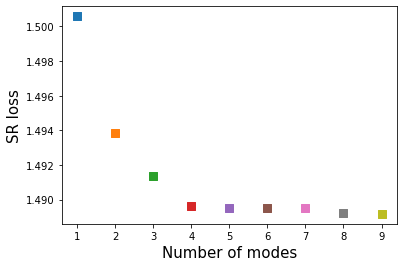

In [242]:
plt.scatter(range(1,10),np.min(np.mean(ls['SR'],axis=-1),axis=-1), 64,color=colors,marker='s')
plt.xlabel('Number of modes',fontsize=15)
plt.ylabel('SR loss',fontsize=15)
# I'll need to make a custom legend for this!
#plt.legend()
plt.show()

In [237]:
np.min(np.mean(ls['SR'],axis=-1),axis=-1)

array([1.50058625, 1.4938633 , 1.49133878, 1.48963509, 1.48953474,
       1.48952079, 1.48951328, 1.48922951, 1.48917363])